# Building a GARCH model for Predicting And Forecasting Stock Volatility

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

## Fetching and Visualizing Nifty-50 Data using Yahoo Finance

In [2]:
nifty = yf.download("^NSEI", start="2018-01-01", end="2024-02-01", progress=False)
nifty = nifty[['Close']]
nifty.reset_index(inplace=True)
nifty.columns = ['date', 'p']

In [3]:
nifty['trading_day'] = range(1, len(nifty) + 1)
nifty['date'] = pd.to_datetime(nifty['date'])
nifty.set_index('trading_day', inplace=True)

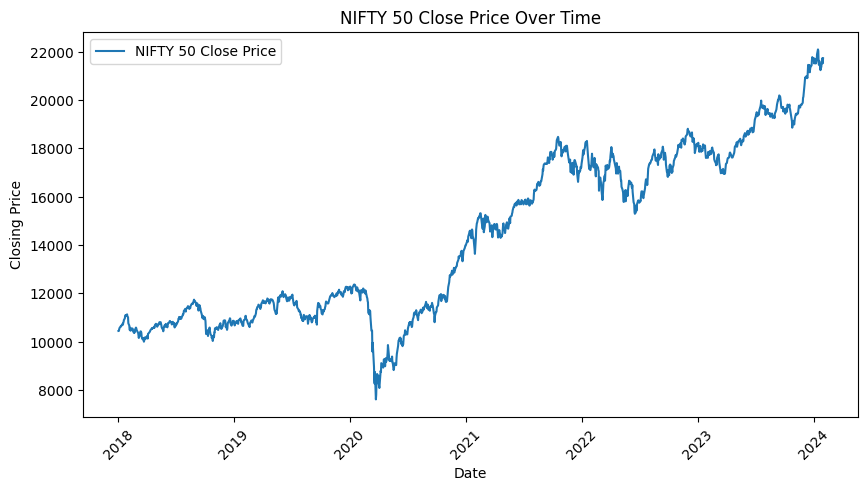

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(nifty['date'], nifty['p'], label="NIFTY 50 Close Price") 
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("NIFTY 50 Close Price Over Time")
plt.xticks(rotation=45)  
plt.legend()
plt.show()

## Making the Series Stationary

In [5]:
adf_result = adfuller(nifty['p'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: 0.08908890005849157
p-value: 0.9653081986134128


Since p-value>0.05 the series is not stationary so we apply log transformation

In [6]:
nifty['log_return'] = np.log(nifty['p'] / nifty['p'].shift(1))
nifty.dropna(inplace=True)

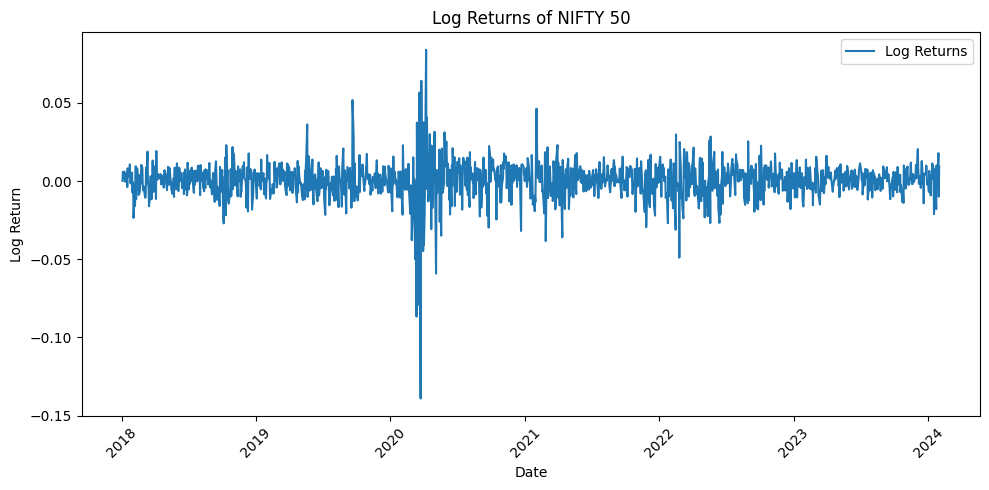

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(nifty['date'], nifty['log_return'], label="Log Returns")
plt.title("Log Returns of NIFTY 50")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
adf_result = adfuller(nifty['log_return'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: -11.055023220068113
p-value: 4.9697670758026523e-20


Since p-value<0.05 the series is stationary

## Choosing the Model

### 1. ARIMA 

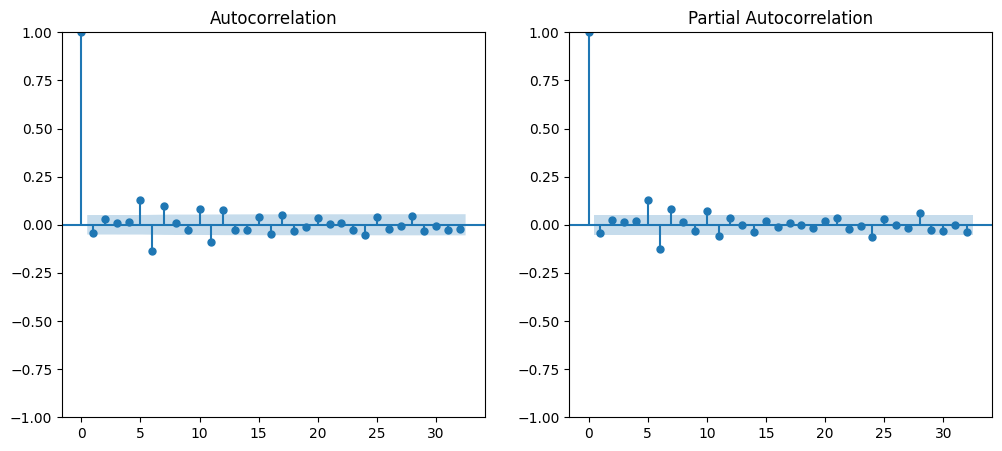

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(nifty['log_return'], ax=ax[0])   # ACF
plot_pacf(nifty['log_return'], ax=ax[1])  # PACF
plt.show()

From both the acf and pacf plot we can see that they lag at first time step itself so we choose p=1 and q=1

In [10]:
arima_model = ARIMA(nifty['log_return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 1497
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4557.263
Date:                Wed, 05 Feb 2025   AIC                          -9106.525
Time:                        20:13:15   BIC                          -9085.280
Sample:                             0   HQIC                         -9098.610
                               - 1497                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.542      0.123      -0.000       0.001
ar.L1         -0.3584      0.183     -1.959      0.050      -0.717    9.25e-05
ma.L1          0.3159      0.189      1.669      0.0

### 2. GARCH(1,1)

In [11]:
garch_1_1 = arch_model(nifty["log_return"], vol="Garch", p=1, q=1)
garch_1_1_fit = garch_1_1.fit(disp="off")

print("GARCH(1,1) Model Summary:")
print(garch_1_1_fit.summary())

GARCH(1,1) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4898.96
Distribution:                  Normal   AIC:                          -9789.91
Method:            Maximum Likelihood   BIC:                          -9768.67
                                        No. Observations:                 1497
Date:                Wed, Feb 05 2025   Df Residuals:                     1496
Time:                        20:13:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.2351e-04  2.273e-04

### 3.GARCH(2,1)

In [12]:
garch_2_1 = arch_model(nifty["log_return"], vol="Garch", p=2, q=1)
garch_2_1_fit = garch_2_1.fit(disp="off")

print("GARCH(2,1) Model Summary:")
print(garch_2_1_fit.summary())

GARCH(2,1) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4895.51
Distribution:                  Normal   AIC:                          -9781.02
Method:            Maximum Likelihood   BIC:                          -9754.47
                                        No. Observations:                 1497
Date:                Wed, Feb 05 2025   Df Residuals:                     1496
Time:                        20:13:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.1317e-04  1.549e-05

### 4. GARCH(1,2)

In [13]:
garch_1_2 = arch_model(nifty["log_return"], vol="Garch", p=1, q=2)
garch_1_2_fit = garch_1_2.fit(disp="off")

print("GARCH(1,2) Model Summary:")
print(garch_1_2_fit.summary())

GARCH(1,2) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4895.40
Distribution:                  Normal   AIC:                          -9780.79
Method:            Maximum Likelihood   BIC:                          -9754.24
                                        No. Observations:                 1497
Date:                Wed, Feb 05 2025   Df Residuals:                     1496
Time:                        20:13:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.2499e-04  2.668e-04

### 5. EGARCH(1,1)

In [14]:
egarch_1_1 = arch_model(nifty["log_return"], vol="EGarch", p=1, q=1)
egarch_1_1_fit = egarch_1_1.fit(disp="off")

print("EGARCH(1,1) Model Summary:")
print(egarch_1_1_fit.summary())

EGARCH(1,1) Model Summary:
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                4898.00
Distribution:                  Normal   AIC:                          -9787.99
Method:            Maximum Likelihood   BIC:                          -9766.75
                                        No. Observations:                 1497
Date:                Wed, Feb 05 2025   Df Residuals:                     1496
Time:                        20:13:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.2619e-04  3.812e-0

### 6. GJR-GARCH(1,1)

In [15]:
gjr_garch_1_1 = arch_model(nifty["log_return"], vol="Garch", p=1, q=1, power=1)
gjr_garch_1_1_fit = gjr_garch_1_1.fit(disp="off")

print("GJR-GARCH(1,1) Model Summary:")
print(gjr_garch_1_1_fit.summary())

GJR-GARCH(1,1) Model Summary:
                    Constant Mean - AVGARCH Model Results                     
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    AVGARCH   Log-Likelihood:                4895.71
Distribution:                  Normal   AIC:                          -9783.43
Method:            Maximum Likelihood   BIC:                          -9762.18
                                        No. Observations:                 1497
Date:                Wed, Feb 05 2025   Df Residuals:                     1496
Time:                        20:13:15   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.8662e-04  2.008

### The Best Model

In [16]:
models = [
    ("ARIMA(1,0,1)", arima_result.aic, arima_result.bic),
    ("GARCH(1,1)", garch_1_1_fit.aic, garch_1_1_fit.bic),
    ("GARCH(2,1)", garch_2_1_fit.aic, garch_2_1_fit.bic),
    ("GARCH(1,2)", garch_1_2_fit.aic, garch_1_2_fit.bic),
    ("EGARCH(1,1)", egarch_1_1_fit.aic, egarch_1_1_fit.bic),
    ("GJR-GARCH(1,1)", gjr_garch_1_1_fit.aic, gjr_garch_1_1_fit.bic)
]

print("\nModel Comparison (AIC & BIC):")
for model in models:
    print(f"{model[0]} - AIC: {model[1]}, BIC: {model[2]}")

best_model_aic = min(models, key=lambda x: x[1])
best_model_bic = min(models, key=lambda x: x[2])

print("\nBest Model based on AIC:", best_model_aic[0], "with AIC =", best_model_aic[1])
print("Best Model based on BIC:", best_model_bic[0], "with BIC =", best_model_bic[2])


Model Comparison (AIC & BIC):
ARIMA(1,0,1) - AIC: -9106.525166754629, BIC: -9085.28029321695
GARCH(1,1) - AIC: -9789.911807049142, BIC: -9768.666933511464
GARCH(2,1) - AIC: -9781.021841383292, BIC: -9754.465749461193
GARCH(1,2) - AIC: -9780.791417412112, BIC: -9754.235325490014
EGARCH(1,1) - AIC: -9787.991204546579, BIC: -9766.7463310089
GJR-GARCH(1,1) - AIC: -9783.426849437848, BIC: -9762.18197590017

Best Model based on AIC: GARCH(1,1) with AIC = -9789.911807049142
Best Model based on BIC: GARCH(1,1) with BIC = -9768.666933511464


## Residual Analysis of Chosen GARCH Model 

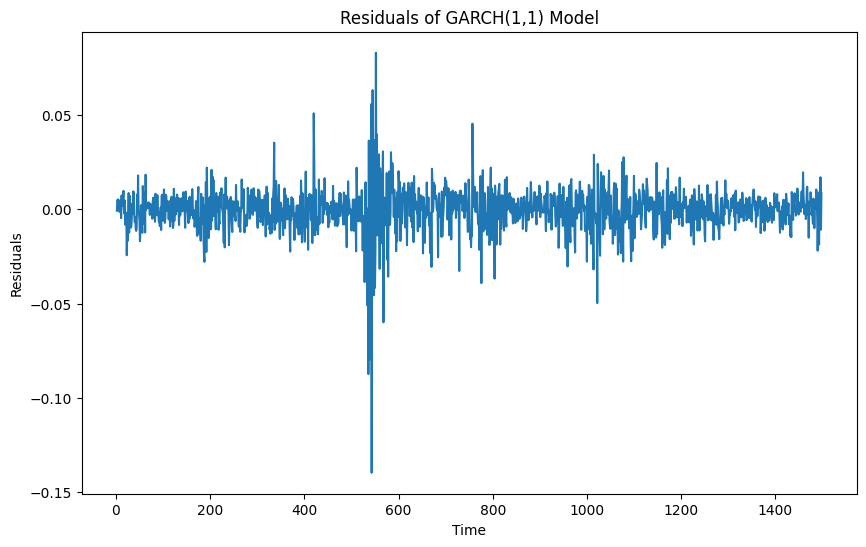

In [17]:
residuals = garch_1_1_fit.resid.dropna()

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residuals of GARCH(1,1) Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

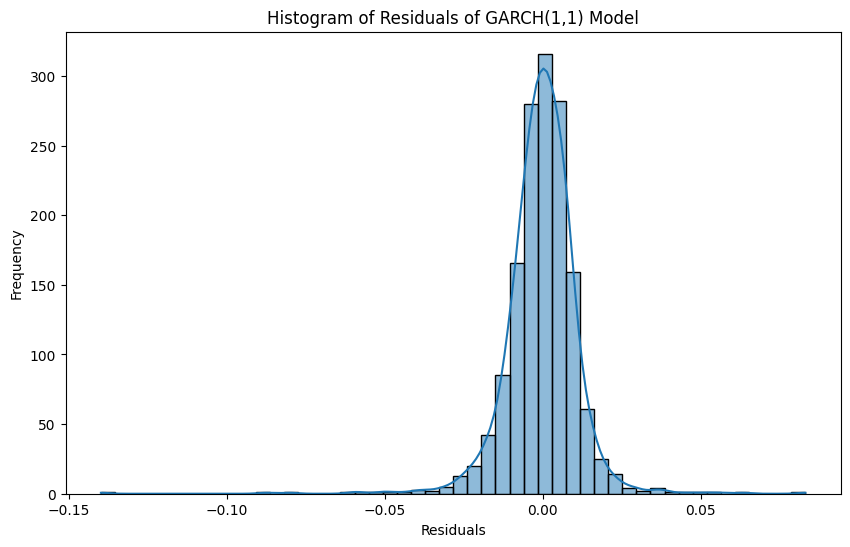

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title("Histogram of Residuals of GARCH(1,1) Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

The graph shows that the residues form a bell curve with mean 0 so they are residues show normality

<Figure size 1000x600 with 0 Axes>

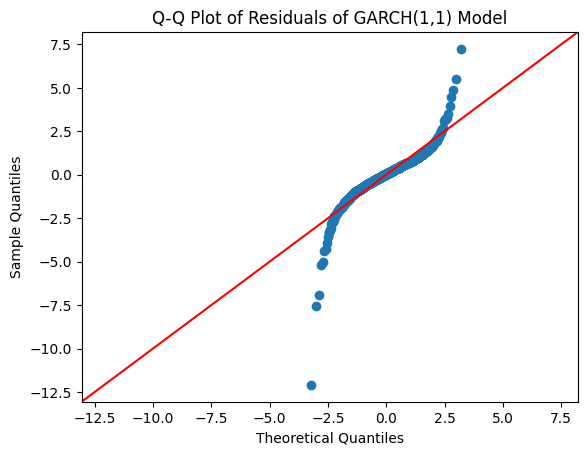

In [19]:
plt.figure(figsize=(10, 6))
qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals of GARCH(1,1) Model")
plt.show()

The q-q plot shows a straight line which again shows that the residues are normally distributed

## Model Prediction

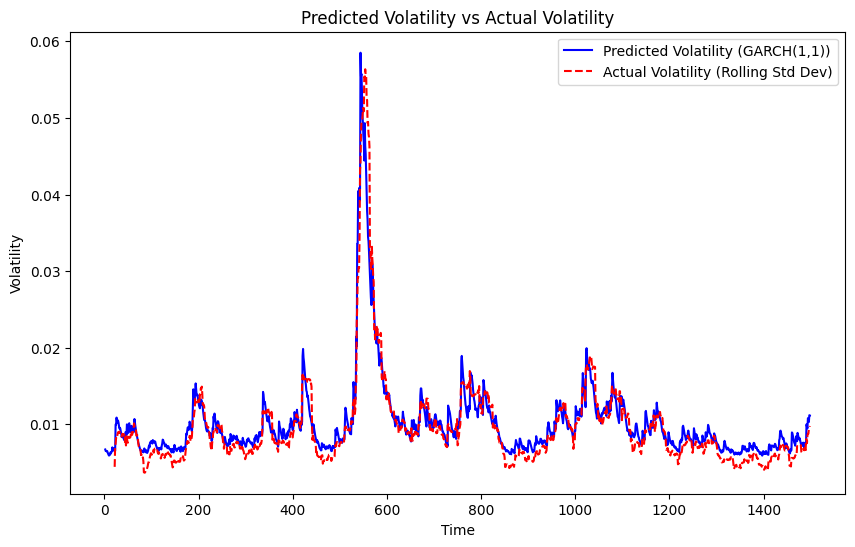

In [20]:
predicted_volatility = garch_1_1_fit.conditional_volatility
actual_volatility = nifty['log_return'].rolling(window=21).std() 

plt.figure(figsize=(10, 6))
plt.plot(predicted_volatility, label="Predicted Volatility (GARCH(1,1))", color='blue')
plt.plot(actual_volatility, label="Actual Volatility (Rolling Std Dev)", color='red', linestyle='--')
plt.title("Predicted Volatility vs Actual Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

## Model Evaluation

In [21]:
predicted_volatility = garch_1_1_fit.conditional_volatility
actual_volatility = nifty['log_return'].rolling(window=21).std().dropna()

min_length = min(len(predicted_volatility), len(actual_volatility))
predicted_volatility = predicted_volatility[-min_length:]
actual_volatility = actual_volatility[-min_length:]

mae = mean_absolute_error(actual_volatility, predicted_volatility)
rmse = np.sqrt(mean_squared_error(actual_volatility, predicted_volatility))
rme = np.mean(np.abs((actual_volatility - predicted_volatility) / actual_volatility)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"RME: {rme}%")

MAE: 0.0013507647163841481
RMSE: 0.001983207948509986
RME: 15.861508031293809%


The MAE,RMSE,RME values are quite small for voltality range of 0-0.06 so the model is fairly good for volatility forecasting

## Model Forecasting

In [22]:
garch_forecast = garch_1_1_fit.forecast(horizon=30)
forecasted_variance = garch_forecast.variance.iloc[-1].values
forecasted_volatility = np.sqrt(forecasted_variance)
print("Forecasted Volatility for the next 30 days:")
print(forecasted_volatility)

Forecasted Volatility for the next 30 days:
[0.01092401 0.01093662 0.01094897 0.01096106 0.01097289 0.01098447
 0.01099581 0.01100691 0.01101778 0.01102842 0.01103884 0.01104904
 0.01105903 0.0110688  0.01107838 0.01108775 0.01109693 0.01110592
 0.01111472 0.01112334 0.01113178 0.01114005 0.01114814 0.01115607
 0.01116383 0.01117143 0.01117888 0.01118617 0.01119331 0.0112003 ]
